# Joe's guide to TensorFlow 2.0

## What's the absolute minimum I need to know?

* Graph/session concepts
* Basic data structures: `EagerTensor`, `Variable`
* For working with neural networks: `tf.keras` API
* For getting data into neural networks: `tf.data` API
* For monitoring training: `tensorboard`
* For advanced stuff: `tf.GradientTape`, `tf.function`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import os
#os.system("export KMP_DUPLICATE_LIB_OK=TRUE")
os.environ['KMP_DUPLICATE_LIB_OK']='True'

tf.enable_v2_behavior()
%matplotlib inline
from IPython.core.pylabtools import figsize

# Graphs and Sessions

## Graphs

TensorFlow represents the sequence of calculations in your program as a directed acyclic graph. This makes it possible to do **automatic differentiation:** if you want the derivative of your loss function with respect to model weights, it can trace the chain rule from calculus up the graph.

* In TF1.x the graph (by default) is something you might directly interact with. It's more than a little clumsy and can be counterintuitive to Python programmers- for example, if a Python variable goes out of score, the operation it represents might still stay on the graph.
* In TF2 "eager execution" is the default- TensorFlow dynamically builds/updates the graph as you go, so you shouldn't be spending your time thinking about it. This makes it **much easier** to prototype (and to write unit tests!), but **necessarily comes at a cost to performance**- so we'll add some tools later to tell your code to de-eagerfy itself when you have a piece you want to run faster.

## Sessions

The other nice thing about abstracting your code to a graph is that it can be optimized to run on different types of hardware. All of the actual calculations in TensorFlow happen inside a `Session` object that manages the actual placement and updating of variables in memory.

* Again, in TF1.x you would explicitly call `tf.Session()` after building your graph and manage it manually
* Now all that stuff happens under the hood, which is really convenient when it works (but harder to debug when it doesn't)

# Data structures

* the main data structure in TensorFlow is the `Tensor`
* in TF2 the default us `EagerTensor`, which you can *mostly* treat the way you'd treat a `numpy` array. Some differences:
  * tensors are immutable- can't set `mytensor[3] = 4` like you could with an array
  * tensorflow is still more sensitive to type than most other Python tools. If your workflow starts with `numpy` you can run into issues (`numpy` default for floats is float64; for deep learning on a GPU float32 is much more common). I spend a lot less time chasing down error messages when I explicitly set `dtype` when defining a tensor.
  * can extract a `numpy` array by calling `mytensor.numpy()`. Note that this copies information from GPU to your CPU!
  * broadcasting semantics are similar to `numpy` (dimensions compatible when equal or one of them is a 1)
* basic math operations live in `tf.math` and work similarly to their `numpy` counterparts (vectorized elementwise calculation, etc).
  * Since you're probably going to be computing gradients in TF, you're more likely to run into numerical computation issues; it's a good habit to stabilize your code as you go (for example, writing `tf.math.log(prob_tensor+epsilon)` instead of `tf.math.log(prob_tensor)`). When possible, use higher-level tensorflow functions (e.g. `tf.nn.softmax` instead of writing your own softmax) since they'll take care of this for you.

In [2]:
# define a simple tensor
foo = tf.zeros([1,2], dtype=tf.float32)
type(foo)

tensorflow.python.framework.ops.EagerTensor

In [3]:
foo

<tf.Tensor: id=2, shape=(1, 2), dtype=float32, numpy=array([[0., 0.]], dtype=float32)>

In [4]:
# pull out a numpy array

In [5]:
foo.numpy()

array([[0., 0.]], dtype=float32)

In [6]:
# tensor.shape returns a TensorShape object instead of a tuple
foo.shape

TensorShape([1, 2])

In [7]:
# use as_list() if you want a normal data structure for the shape
foo.shape.as_list()

[1, 2]

In [8]:
# TF is reasonably forgiving on doing basic elementwise math on tensors
bar = foo+2
bar

<tf.Tensor: id=6, shape=(1, 2), dtype=float32, numpy=array([[2., 2.]], dtype=float32)>

In [9]:
higher_rank_tensor = tf.ones((1,2,7), dtype=tf.float32)

In [10]:
product = higher_rank_tensor*bar

InvalidArgumentError: Incompatible shapes: [1,2,7] vs. [1,2] [Op:Mul] name: mul/

In [11]:
product2 = higher_rank_tensor*tf.reshape(bar, (1,2,1))
product2.shape

TensorShape([1, 2, 7])

In [12]:
(np.ones((1,2,7))*np.ones((1,2,1))).shape

(1, 2, 7)

## Variables

Variables are a subclass of Tensors- generally, the weights of your models will be variables.

In [13]:
myvar = tf.Variable(np.random.uniform(0,1,(1,2)).astype(np.float32))
myvar

<tf.Variable 'Variable:0' shape=(1, 2) dtype=float32, numpy=array([[0.891858 , 0.7904143]], dtype=float32)>

In [14]:
# operations that input a variable and a tensor, output a tensor
myvar+bar

<tf.Tensor: id=25, shape=(1, 2), dtype=float32, numpy=array([[2.891858 , 2.7904143]], dtype=float32)>

In [15]:
# we can manually assign new values to a variable
myvar.assign_add(bar)

<tf.Variable 'UnreadVariable' shape=(1, 2) dtype=float32, numpy=array([[2.891858 , 2.7904143]], dtype=float32)>

In [16]:
myvar

<tf.Variable 'Variable:0' shape=(1, 2) dtype=float32, numpy=array([[2.891858 , 2.7904143]], dtype=float32)>

# When building a neural network: use `tf.keras`

* In the bad old days: choose between `tf-slim`, `tf.layers`, `tf.estimator`, `skflow`, or `keras` for your high-level API
* `keras` used to be really restrictive but it's become a lot more extensible over the last year. it is now **the** supported high-level API for tensorflow
* that being said, the farther you drag it away from what's included, the more likely you are to hit really annoying edge cases where some `keras` functionality fails

In [17]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
#mnist = tf.keras.datasets.mnist
#(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [18]:
classes = ["tshirt", "trouser", "pullover", "dress",
           "coat", "sandal", "shirt", "sneaker",
           "bag", "ankle-boot"]

In [19]:
train_images.shape

(60000, 28, 28)

In [20]:
train_images = train_images.reshape((-1, 28, 28, 1)).astype(np.float32)/255
test_images = test_images.reshape((-1, 28, 28, 1)).astype(np.float32)/255

In [62]:
seq_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, input_shape=(28,28,1), activation="relu"),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.GlobalMaxPool2D(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [63]:
seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

In [64]:
seq_model.compile(tf.keras.optimizers.Adam(1e-3),
                 tf.keras.losses.sparse_categorical_crossentropy,
                 metrics=["accuracy"])

In [65]:
seq_model.fit(train_images, train_labels,
             batch_size=64,
             validation_data=(test_images, test_labels),
             epochs=5,
             callbacks=[
                 tf.keras.callbacks.TensorBoard("logs/")
             ])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 28s 471us/sample - loss: 0.6351 - accuracy: 0.7688 - val_loss: 0.4627 - val_accuracy: 0.8293
Epoch 2/2
60000/60000 [==============================] - 28s 464us/sample - loss: 0.4094 - accuracy: 0.8490 - val_loss: 0.4018 - val_accuracy: 0.8540


From the command line, run

> tensorboard --logdir logs/

To see the callbacks we saved out

In [25]:
predictions = seq_model.predict(test_images[:20])
predictions.shape

(20, 10)

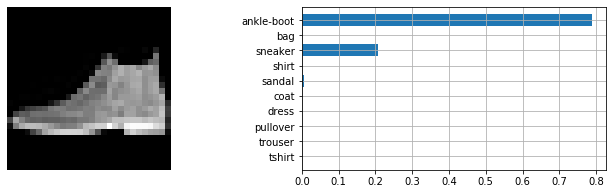

In [27]:
figsize(12,3)
i = 0
plt.subplot(121)
plt.imshow(test_images[i,:,:,0], cmap=plt.cm.gray)
plt.axis("off")
plt.subplot(122)
plt.barh(np.arange(10), predictions[i,:])
plt.yticks(np.arange(10), classes)
plt.grid(True);

You can write the model to disk to retrieve later using `Model.save()`. Historically this had used HDF5 but with TF2 more integration is coming with the tensorflow-specific `SavedModel` format. HDF5 has trouble with custom objects and nested models.

In [28]:
seq_model.save("seq_model.h5")

### Some things to know about `tf.keras`

#### Layer objects

In the sequential model above, each line like 

`tf.keras.layers.Dense(10, activation="softmax")`

defines a layer object; calling it on a tensor
```
mylayer = tf.keras.layers.Dense(10, activation="softmax")
output_tensor = mylayer(input_tensor)
```
runs the tensor through that layer and returns a new tensor representing the output. If you want to reuse a layer in a network (for example, reusing an embedding layer for a text processing network), build the layer once and call it in multiple places.

#### Other ways to define models in `tf.keras`

There are two other APIs for model definition in Keras:

* **functional API:** a bit more verbose than sequential, but lets you define models with multiple inputs and outputs (my personal favorite. examples later)
* **subclassing API:** if you want tons of flexibility, you can directly subclass `tf.keras.Model`. Note that a lot of the convenience methods tend to break when you do this (like `Model.save()`).

#### Building more complicated models

Modern neural networks often contain complex substructures- like transformers in NLP or residual and inception blocks in computer vision. Manually spelling out every layer in every substructure is clumsy; we have two options for getting around it:

* **Nesting models:** you can call a keras model as a layer in another model. You can build more complex models without learning anything new, but you're limited to combinations of existing layers.
* **Custom layers:** keras has an API spec to define a custom class for a new layer. This is much more flexible but you have to get your hands dirty with lower-level tensorflow or `tf.keras.backend` functions.


## Getting data into tensorflow: use `tf.data`

In the sequential model above, we passed data as `numpy` arrays directly into keras' `Model.fit()` method, which is fine as long as all our data fits into memory. When we scale up our models, we'll generally want any loading, preprocessing, and augmentation to be done on the CPU and in separate threads so that our GPU is never sitting around waiting for the next batch. The `tf.data.Dataset` API is a little idiosyncratic but makes this process pretty easy.

To create the dataset we'll use `from_tensor_slices()`, which can input the `numpy` arrays we already have. This makes it easy to prototype our loaders using in-memory datasets; later on we can replace that line with code that loads the data from disk:

In [29]:
# define a dataset object
ds = tf.data.Dataset.from_tensor_slices((train_images.astype(np.float32), train_labels.astype(np.int64)))

Let's also define a function that does some augmentation on our data (we can make this as complicated as we want):

In [30]:
def augment(img, label):
    return tf.image.random_flip_left_right(img), label

Map that function across the dataset, then do some boilerplate shuffling, batching, and prefetching:

In [31]:
batch_size = 32

# map through an augmentation function
ds = ds.map(augment, num_parallel_calls=2)
# shuffle dataset by randomly drawing from a queue of the next 1000 examples
ds = ds.shuffle(1000)
# assemble examples into batches of size 64
ds = ds.batch(batch_size)
# prefetch the next batch
ds = ds.prefetch(1)

In [32]:
ds

<DatasetV1Adapter shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>

To use with keras' `Model.fit()` we'll need to specify how many steps there are per epoch- which isn't hard, but is annoying to have to do manually.

```
numsteps = int(np.ceil(len(train_labels)/64))
mmymodel.fit(ds, steps_per_epoch=numpsteps, epochs=5)
```

We can also call the dataset as a Python *iterable* (**not** an *iterator*):

In [33]:
for x, y in ds:
    break

In [34]:
print(type(x))
print(x.get_shape())

<class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 28, 28, 1)


In [35]:
print(type(y))
print(y.get_shape())

<class 'tensorflow.python.framework.ops.EagerTensor'>
(32,)


I'll show an example of what we can do with this later in the notebook.

## Monitoring training with TensorBoard

Neural nets can take a while to train- if you're used to a "run everything interactively in a jupyter notebook" style of doing data science, it's really easy to accidentally waste a bunch of time when something goes horribly wrong and you don't find out til after your GPU chewed on it for 100 epochs. It's always a good idea to have some way to monitor progress (even if it's just printing stuff out in your notebook).

Tensorboard is a command-line program that gets installed with tensorflow, that displays summaries stored in event files. 

In the `keras` example above we used a callback to save logs- you can also customize Tensorboard outputs quite a lot. I've always found the Python interface to be a little clumsy, but it's been streamlined somewhat in 2.0. We need to define a "writer" and give it a path to a log directory:

In [59]:
writer = tf.compat.v2.summary.create_file_writer("logs2/", flush_millis=10000)
writer.set_as_default()

Then, in our training (and/or evaluation) loops, call `summary` functions to record some information. Each one will take:

* a name for the summary (as a string)
* a `numpy` array or a tensor for the data
* an integer `step` that's used to order and align everything
* (this is new) a markdown-formatted string describing what you're summarizing

For a simple contrived example of some data to record- let's put a cursor on a 10x10 grid and every step randomly move it to an adjacent space (with toroidal boundary conditions):

In [60]:
num_steps= 1000

img= np.zeros((1, 10, 10, 1))
x = 5
y = 5

# every step:
for s in range(num_steps):
    x = (x + np.random.choice([-1, 0, 1]))%10
    y = (y + np.random.choice([-1, 0, 1]))%10
    img[0, y, x, 0] += 0.05
    img[img > 1] = 0
        
    tf.compat.v2.summary.scalar("x", x, step=s, description="Current value of **x**")
    tf.compat.v2.summary.scalar("y", y, step=s, description="Current value of **y**")
    
    tf.compat.v2.summary.histogram("cell_values", img, step=s)
    tf.compat.v2.summary.image("full_image", img, step=s)
    

## For building weird stuff: `tf.GradientTape` and `@tf.function`

When eager execution is computing things on-the-fly, it doesn't keep track of gradients unless you tell it to. Use a `tf.GradientTape()` block to tell TensorFlow to hold on to that information; when you're done you can call `tape.gradient` to compute the gradient of one value with respect to another.

For example- let's take our trained image classifier and compute gradients of the output with respect to an input image, so that we can see how it's flagging off different parts of the image:

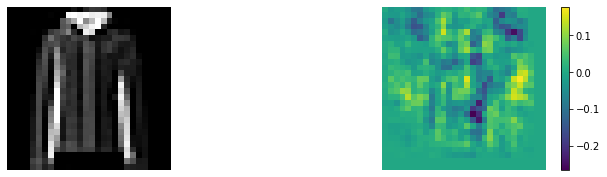

In [74]:
i = 6

img = tf.constant(test_images[i].reshape((1,28,28,1)))
label = tf.constant(test_labels[i].astype(np.int32))

with tf.GradientTape() as tape:
    tape.watch(img)
    predictions = seq_model(img)[0,label]
    
grad = tape.gradient(predictions, img)

plt.subplot(121)
plt.imshow(test_images[i,:,:,0], cmap=plt.cm.gray)
plt.axis("off")
plt.subplot(122)
plt.imshow(grad[0,:,:,0])
plt.colorbar()
plt.axis("off");

If you're familiar with adversarial learning, you might recognize this as the first step in the **fast gradient sign method** of building adversarial examples- we repeatedly use the sign of the gradient to increment an image, to try and force a misclassification.

Since FGSM repeats this calculation a bunch of times, we'd prefer not to have eager execution building dynamic graphs as we go- we'd prefer performance to flexibility. The `@tf.function` decorator will attempt to compile your function into a static Tensorflow graph:

In [100]:
@tf.function
def fgsm(img, label, steps=25, eps=1e-3):
    for s in range(steps):    
        with tf.GradientTape() as tape:
            tape.watch(img)
            predictions = seq_model(img)[0,label]
    
            grad = tape.gradient(predictions, img)
            img.assign_sub(eps*tf.sign(grad))
    return img

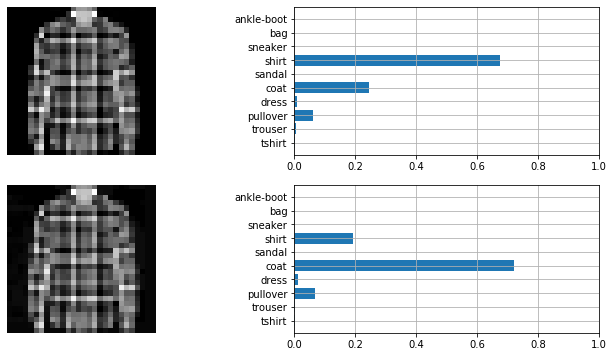

In [108]:
i = 7

img = tf.Variable(test_images[i].reshape((1,28,28,1)))
label = tf.constant(test_labels[i].astype(np.int32))

img = fgsm(img, label)

figsize(12,6)
plt.subplot(221)
plt.imshow(test_images[i,:,:,0], cmap=plt.cm.gray)
plt.axis("off")
plt.subplot(222)
plt.barh(np.arange(10), seq_model(test_images[i,:,:,:].reshape(1,28,28,1)).numpy().flatten())
plt.yticks(np.arange(10), classes)
plt.xlim(0,1)
plt.grid(True)

plt.subplot(223)
plt.imshow(img.numpy()[0,:,:,0], cmap=plt.cm.gray)
plt.axis("off")
plt.subplot(224)
plt.barh(np.arange(10), seq_model(img).numpy().flatten())
plt.yticks(np.arange(10), classes)
plt.xlim(0,1)
plt.grid(True);

In [81]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Reshape((7, 7, 256)),

    tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid')
])

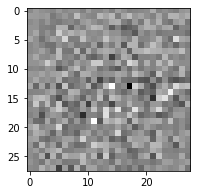

In [82]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray');

In [83]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [84]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [85]:
def discriminator_loss(real_output, fake_output):
    # when training the discriminator- should try to predict 1 for real images
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    # and 0 for fake images
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return tf.reduce_sum(total_loss)

def generator_loss(fake_output):
    # when training the generator- should try to get the discriminator to incorrectly
    # classify fake images as 1 instead of 0
    return tf.reduce_sum(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))

In [86]:
@tf.function
def train_step(images, batch_size, noise_dim):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [87]:
from tqdm import tqdm

In [92]:
num_epochs = 1
noise_dim = 100
gen_losses = []
disc_losses = []

for e in tqdm(range(num_epochs)):
    for x, y in ds:
        g, d = train_step(x, batch_size, noise_dim)
        
        gen_losses.append(g.numpy())
        disc_losses.append(d.numpy())


100%|██████████| 1/1 [11:43<00:00, 703.77s/it]

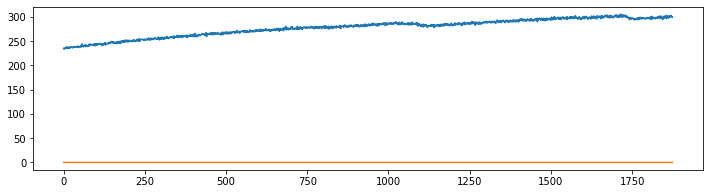

In [93]:
plt.plot(gen_losses)
plt.plot(disc_losses)

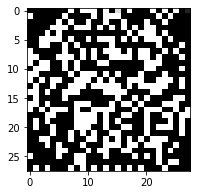

In [94]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray');

In [74]:
foo = generator(np.random.normal(0,1,(32,100)))

In [77]:
bar = discriminator(foo)

In [79]:
generator_loss(bar)

<tf.Tensor: id=1549839, shape=(32,), dtype=float32, numpy=
array([13.195828, 13.211996, 13.179918, 13.211996, 13.211996, 13.211996,
       13.211996, 13.195828, 13.211996, 13.211996, 13.245135, 13.245135,
       13.245135, 13.211996, 13.228429, 13.211996, 13.211996, 13.211996,
       13.211996, 13.195828, 13.195828, 13.262127, 13.211996, 13.211996,
       13.195828, 13.195828, 13.211996, 13.245135, 13.179918, 13.195828,
       13.211996, 13.211996], dtype=float32)>

In [80]:
tf.keras.losses.BinaryCrossentropy?

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    #display.clear_output(wait=True)
    #generate_and_save_images(generator,
    #                       epochs,
    #                       seed)